# Automated Melanoma Detection with XAI (PyTorch)

This section builds an end-to-end melanoma detector in PyTorch and visualizes explanations with Grad-CAM.

You’ll run cells in order:
1) Setup and config
2) Load metadata and split
3) Dataset and transforms
4) Model + training/evaluation helpers
5) Train (with early stopping)
6) Grad-CAM visualizations
7) Single-image inference demo

In [1]:
# 1) Setup/config with robust paths
import os
from pathlib import Path
import random
import numpy as np
import torch

# Resolve project root by finding where data/HAM10000_metadata.csv exists
CWD = Path.cwd()
candidates = [CWD, CWD.parent, CWD.parent.parent]
ROOT = CWD
for root in candidates:
    if (root / 'data' / 'HAM10000_metadata.csv').exists():
        ROOT = root
        break

DATA_DIR = ROOT / 'data'
IMG_DIR = DATA_DIR / 'ds' / 'img'
META_CSV = DATA_DIR / 'HAM10000_metadata.csv'
MODELS_DIR = ROOT / 'models'
CHECKPOINTS_DIR = MODELS_DIR / 'checkpoints'
LABEL_MAPS_DIR = MODELS_DIR / 'label_maps'
CHECKPOINTS_DIR.mkdir(parents=True, exist_ok=True)
LABEL_MAPS_DIR.mkdir(parents=True, exist_ok=True)
CHECKPOINT_PATH = CHECKPOINTS_DIR / 'melanoma_resnet50_nb.pth'
LABEL_MAP_PATH = LABEL_MAPS_DIR / 'label_map_nb.json'

# Hyperparams
SEED = 42
BATCH_SIZE = 32
EPOCHS = 10
LR = 3e-4
IMG_SIZE = 224

# Device and seeds
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

print('Device:', DEVICE)
print('Project root:', str(ROOT))
print('Meta CSV:', str(META_CSV))
print('Images dir:', str(IMG_DIR))

# Cast to str for downstream os.path.join usage
IMG_DIR = str(IMG_DIR)
META_CSV = str(META_CSV)
CHECKPOINT_PATH = str(CHECKPOINT_PATH)
LABEL_MAP_PATH = str(LABEL_MAP_PATH)

# Initialize globals used by later cells to keep linters/static-checkers happy
cam = None

Device: cuda
Project root: /home/the/Codes/Melanoma-detection
Meta CSV: /home/the/Codes/Melanoma-detection/data/HAM10000_metadata.csv
Images dir: /home/the/Codes/Melanoma-detection/data/ds/img


In [2]:
# 2) Load metadata and split
import pandas as pd
import json
from sklearn.model_selection import train_test_split

meta = pd.read_csv(META_CSV)
labels = meta['dx'].astype('category')
label_map = {cat: i for i, cat in enumerate(labels.cat.categories)}
id2label = {i: k for k, i in label_map.items()}
meta['label'] = meta['dx'].map(label_map)
with open(LABEL_MAP_PATH, 'w') as f:
    json.dump(label_map, f)

train_df, val_df = train_test_split(meta, test_size=0.15, stratify=meta['label'], random_state=SEED)
print('Train:', len(train_df), 'Val:', len(val_df))
print('Classes:', label_map)

Train: 8511 Val: 1502
Classes: {'actinic keratoses': 0, 'basal cell carcinoma': 1, 'benign keratosis-like lesions': 2, 'dermatofibroma': 3, 'melanocytic nevi': 4, 'melanoma': 5, 'vascular lesions': 6}


In [3]:
# 3) Dataset and transforms
from PIL import Image
from torchvision import transforms as T
from torch.utils.data import DataLoader, Dataset

class SkinDataset(Dataset):
    def __init__(self, df, img_dir, transform=None):
        self.df = df.reset_index(drop=True)
        self.img_dir = img_dir
        self.transform = transform
    def __len__(self):
        return len(self.df)
    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img_path = os.path.join(self.img_dir, row['image_id'] + '.jpg')
        img = Image.open(img_path).convert('RGB')
        if self.transform:
            img = self.transform(img)
        return img, int(row['label'])

train_tf = T.Compose([
    T.Resize((IMG_SIZE, IMG_SIZE)),
    T.RandomHorizontalFlip(),
    T.RandomVerticalFlip(),
    T.ColorJitter(brightness=0.2, contrast=0.2),
    T.ToTensor(),
    T.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225])
])
val_tf = T.Compose([
    T.Resize((IMG_SIZE, IMG_SIZE)),
    T.ToTensor(),
    T.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225])
])

train_ds = SkinDataset(train_df, IMG_DIR, transform=train_tf)
val_ds   = SkinDataset(val_df,   IMG_DIR, transform=val_tf)

# class weights + weighted sampler
import numpy as np
counts = np.bincount(train_df['label'].values, minlength=len(label_map))
cls_weights = len(train_df) / (len(label_map) * np.maximum(counts, 1))
sample_w = cls_weights[train_df['label'].values]
from torch.utils.data import WeightedRandomSampler
sampler = WeightedRandomSampler(sample_w, num_samples=len(sample_w), replacement=True)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, sampler=sampler, num_workers=2, pin_memory=True)
val_loader   = DataLoader(val_ds,   batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)

print('Batches:', len(train_loader), len(val_loader))

Batches: 266 47


In [4]:
# 4) Model + helpers
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models
from sklearn.metrics import roc_auc_score

num_classes = len(label_map)
model = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)
model.fc = nn.Linear(model.fc.in_features, num_classes)
model = model.to(DEVICE)

criterion = nn.CrossEntropyLoss(weight=torch.tensor(cls_weights, dtype=torch.float32).to(DEVICE))
optimizer = optim.AdamW(model.parameters(), lr=LR, weight_decay=1e-4)

# Use AMP only for CUDA devices
use_amp = (DEVICE == 'cuda')
if use_amp:
    from torch.amp import autocast, GradScaler
    scaler = GradScaler('cuda')
else:
    scaler = None

@torch.no_grad()
def evaluate(model, loader):
    model.eval()
    probs_all, labels_all = [], []
    for x, y in loader:
        x = x.to(DEVICE)
        logits = model(x)
        probs = torch.softmax(logits, dim=1).cpu().numpy()
        probs_all.append(probs)
        labels_all.append(y.numpy())
    import numpy as np
    probs_all = np.concatenate(probs_all)
    labels_all = np.concatenate(labels_all)
    y_true = np.eye(num_classes)[labels_all]
    try:
        auc_val = roc_auc_score(y_true, probs_all, average='macro', multi_class='ovr')
    except Exception:
        auc_val = float('nan')
    return auc_val


def train_one_epoch():
    model.train()
    running = 0.0
    for x, y in train_loader:
        x, y = x.to(DEVICE), y.to(DEVICE)
        optimizer.zero_grad(set_to_none=True)
        
        if use_amp:
            # Use AMP for CUDA
            with autocast(device_type='cuda'):
                logits = model(x)
                loss = criterion(logits, y)
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
        else:
            # Standard training for CPU
            logits = model(x)
            loss = criterion(logits, y)
            loss.backward()
            optimizer.step()
        
        running += loss.item() * x.size(0)
    return running / len(train_ds)

In [5]:
# 5-alt) Load trained checkpoint (skip training)
import os
import torch

if os.path.exists(CHECKPOINT_PATH):
    ckpt = torch.load(CHECKPOINT_PATH, map_location=DEVICE)
    missing, unexpected = model.load_state_dict(ckpt['state_dict'], strict=False)
    if missing:
        print('Missing keys when loading:', missing)
    if unexpected:
        print('Unexpected keys when loading:', unexpected)
    model.eval()
    print(f"Loaded checkpoint from {CHECKPOINT_PATH}")
else:
    print(f"Checkpoint not found at {CHECKPOINT_PATH}. You can run the training cell to create it.")

Loaded checkpoint from /home/the/Codes/Melanoma-detection/models/checkpoints/melanoma_resnet50_nb.pth


In [6]:
# 5) Train with early stopping
best_auc = -1.0
patience = 3
pat = patience
for epoch in range(EPOCHS):
    train_loss = train_one_epoch()
    val_auc = evaluate(model, val_loader)
    print(f"Epoch {epoch+1}/{EPOCHS} - loss: {train_loss:.4f} - val AUC: {val_auc:.4f}")
    if val_auc > best_auc:
        best_auc = val_auc
        pat = patience
        torch.save({'state_dict': model.state_dict(), 'label_map': label_map}, CHECKPOINT_PATH)
        print(f"  Saved best model to {CHECKPOINT_PATH}")
    else:
        pat -= 1
        if pat == 0:
            print("Early stopping")
            break
# load best for further eval
ckpt = torch.load(CHECKPOINT_PATH, map_location=DEVICE)
model.load_state_dict(ckpt['state_dict'])
model.eval()
print(f"Best val AUC: {best_auc:.4f}")

Epoch 1/10 - loss: 0.3590 - val AUC: 0.8205
  Saved best model to /home/the/Codes/Melanoma-detection/models/checkpoints/melanoma_resnet50_nb.pth
Epoch 2/10 - loss: 0.3193 - val AUC: 0.8410
  Saved best model to /home/the/Codes/Melanoma-detection/models/checkpoints/melanoma_resnet50_nb.pth
Epoch 2/10 - loss: 0.3193 - val AUC: 0.8410
  Saved best model to /home/the/Codes/Melanoma-detection/models/checkpoints/melanoma_resnet50_nb.pth
Epoch 3/10 - loss: 0.3300 - val AUC: 0.8324
Epoch 3/10 - loss: 0.3300 - val AUC: 0.8324
Epoch 4/10 - loss: 0.2591 - val AUC: 0.8430
  Saved best model to /home/the/Codes/Melanoma-detection/models/checkpoints/melanoma_resnet50_nb.pth
Epoch 4/10 - loss: 0.2591 - val AUC: 0.8430
  Saved best model to /home/the/Codes/Melanoma-detection/models/checkpoints/melanoma_resnet50_nb.pth
Epoch 5/10 - loss: 0.2534 - val AUC: 0.8429
Epoch 5/10 - loss: 0.2534 - val AUC: 0.8429
Epoch 6/10 - loss: 0.2234 - val AUC: 0.8673
  Saved best model to /home/the/Codes/Melanoma-detectio

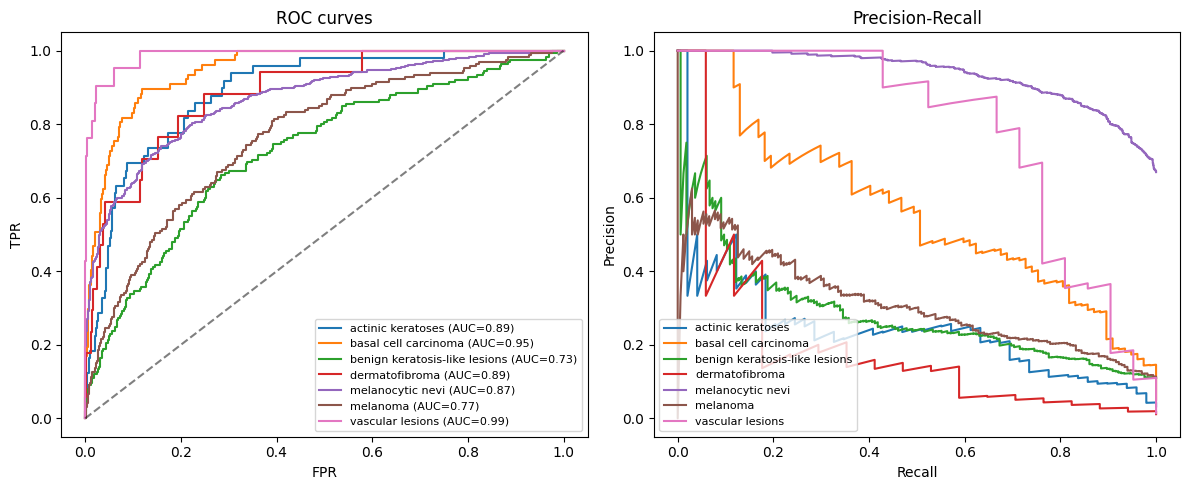

Classification report:
                                precision    recall  f1-score   support

            actinic keratoses       0.24      0.47      0.32        49
         basal cell carcinoma       0.54      0.49      0.52        77
benign keratosis-like lesions       0.23      0.42      0.30       165
               dermatofibroma       0.11      0.41      0.18        17
             melanocytic nevi       0.99      0.29      0.44      1006
                     melanoma       0.20      0.77      0.32       167
             vascular lesions       0.43      0.76      0.55        21

                     accuracy                           0.38      1502
                    macro avg       0.39      0.52      0.37      1502
                 weighted avg       0.75      0.38      0.41      1502



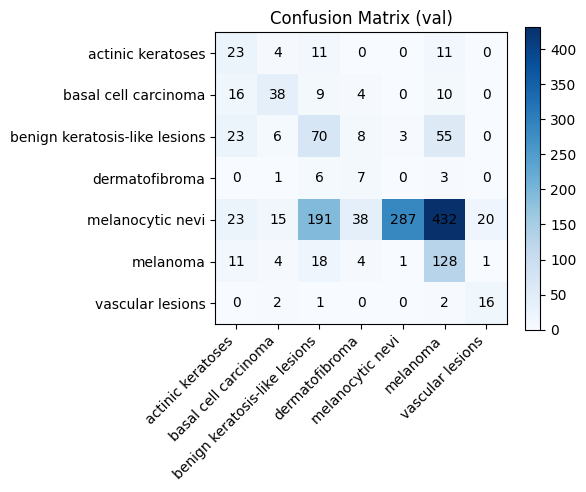

In [7]:
# 6) Evaluation: ROC/PR and confusion matrix
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, precision_recall_curve, confusion_matrix, classification_report

# Ensure id2label exists
try:
    id2label
except NameError:
    id2label = {i: k for k, i in label_map.items()}

# If a torchcam instance exists from a previous cell, try to remove its hooks (optional safety)
if 'cam' in globals():
    try:
        cam.remove_hooks()
        del cam
    except Exception:
        pass

# collect predictions on val set
probs_all, labels_all = [], []
model.eval()
with torch.no_grad():
    for x, y in val_loader:
        x = x.to(DEVICE)
        logits = model(x)
        probs_all.append(torch.softmax(logits, dim=1).cpu().numpy())
        labels_all.append(y.numpy())
probs_all = np.concatenate(probs_all)
labels_all = np.concatenate(labels_all)

# ROC/PR per-class (one-vs-rest)
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
for c, name in id2label.items():
    y_true = (labels_all == c).astype(int)
    y_score = probs_all[:, c]
    fpr, tpr, _ = roc_curve(y_true, y_score)
    prec, rec, _ = precision_recall_curve(y_true, y_score)
    axes[0].plot(fpr, tpr, label=f"{name} (AUC={auc(fpr, tpr):.2f})")
    axes[1].plot(rec, prec, label=name)
axes[0].plot([0,1],[0,1],'k--', alpha=0.5)
axes[0].set_title('ROC curves')
axes[0].set_xlabel('FPR'); axes[0].set_ylabel('TPR')
axes[1].set_title('Precision-Recall')
axes[1].set_xlabel('Recall'); axes[1].set_ylabel('Precision')
for ax in axes: ax.legend(fontsize=8)
plt.tight_layout()
plt.show()

# Confusion matrix at argmax
pred_labels = probs_all.argmax(axis=1)
cm = confusion_matrix(labels_all, pred_labels, labels=list(id2label.keys()))
print('Classification report:\n', classification_report(labels_all, pred_labels, target_names=[id2label[i] for i in sorted(id2label.keys())]))
plt.figure(figsize=(6,5))
plt.imshow(cm, cmap='Blues')
plt.title('Confusion Matrix (val)')
plt.colorbar()
plt.xticks(ticks=range(len(id2label)), labels=[id2label[i] for i in range(len(id2label))], rotation=45, ha='right')
plt.yticks(ticks=range(len(id2label)), labels=[id2label[i] for i in range(len(id2label))])
for i in range(len(id2label)):
    for j in range(len(id2label)):
        plt.text(j, i, cm[i, j], ha='center', va='center', color='black')
plt.tight_layout()
plt.show()

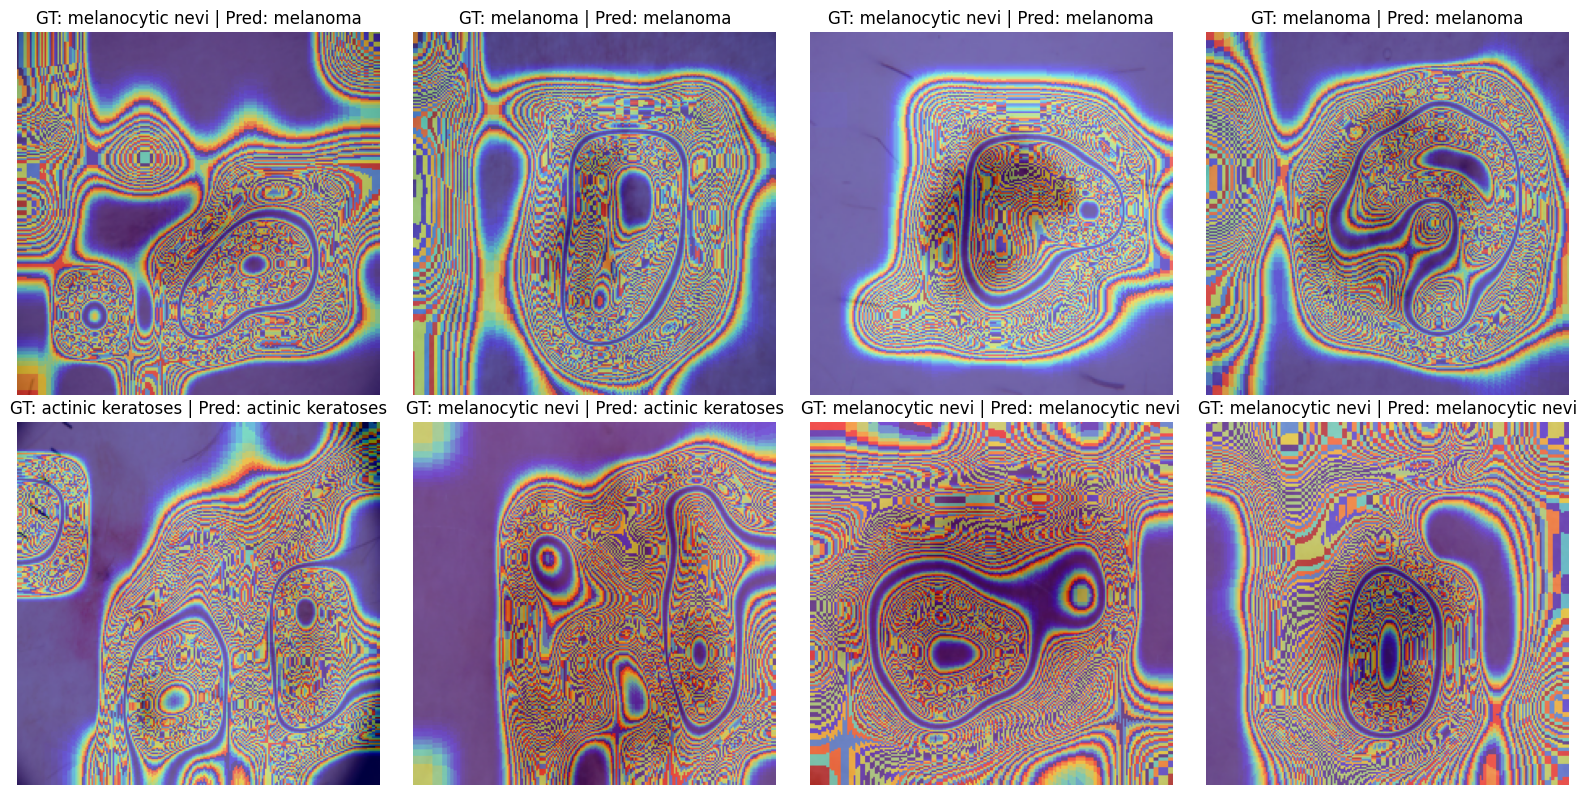

In [8]:
# 7) Grad-CAM visualization on a few val images (de-normalized tensor -> PIL)
try:
    from torchcam.methods import GradCAM
    from torchcam.utils import overlay_mask
    import torchvision.transforms.functional as TF
    
    # Ensure id2label exists
    try:
        id2label
    except NameError:
        id2label = {i: k for k, i in label_map.items()}

    # Remove any existing hooks first
    if 'cam' in globals():
        try:
            cam.remove_hooks()
            del cam
        except Exception:
            pass
    
    # Create GradCAM instance
    cam = GradCAM(model, target_layer='layer4')
    model.eval()
    
    # indices within val_ds
    vis_idx = list(range(0, min(8, len(val_ds))))
    ncols = 4
    nrows = int(np.ceil(len(vis_idx)/ncols))
    plt.figure(figsize=(4*ncols, 4*nrows))

    # ImageNet stats used for normalization earlier
    mean = torch.tensor([0.485, 0.456, 0.406]).view(3,1,1)
    std = torch.tensor([0.229, 0.224, 0.225]).view(3,1,1)

    for k, ds_idx in enumerate(vis_idx, 1):
        x, y = val_ds[ds_idx]
        # de-normalize to [0,1]
        x_denorm = (x * std + mean).clamp(0,1)
        pil_img = TF.to_pil_image(x_denorm)

        # Prepare input with gradient enabled
        x_in = x.unsqueeze(0).to(DEVICE)
        x_in.requires_grad = True
        
        # Forward pass
        logits = model(x_in)
        pred_id = logits.argmax(1).item()
        
        # Compute CAM for predicted class
        activation_map = cam(pred_id, logits)[0].cpu()
        
        # normalize cam to [0,1]
        a = activation_map
        a = (a - a.min()) / (a.max() - a.min() + 1e-6)
        a_img = TF.to_pil_image(a)
        overlay = overlay_mask(pil_img, a_img.resize(pil_img.size), alpha=0.5)
        
        plt.subplot(nrows, ncols, k)
        plt.imshow(overlay)
        plt.axis('off')
        plt.title(f"GT: {id2label[y]} | Pred: {id2label[pred_id]}")
    
    plt.tight_layout()
    plt.show()
    
    # Important: remove hooks so other cells are unaffected
    cam.remove_hooks()
    del cam
    
except Exception as e:
    print("Grad-CAM not available:", e)
    print("Install torchcam or skip this section.")
    import traceback
    traceback.print_exc()

Temperature: 2.5816
ECE  pre=0.2551, post=0.0350
Brier pre=0.1193, post=0.1041
Saved temperature to /home/the/Codes/Melanoma-detection/models/checkpoints/temperature.json


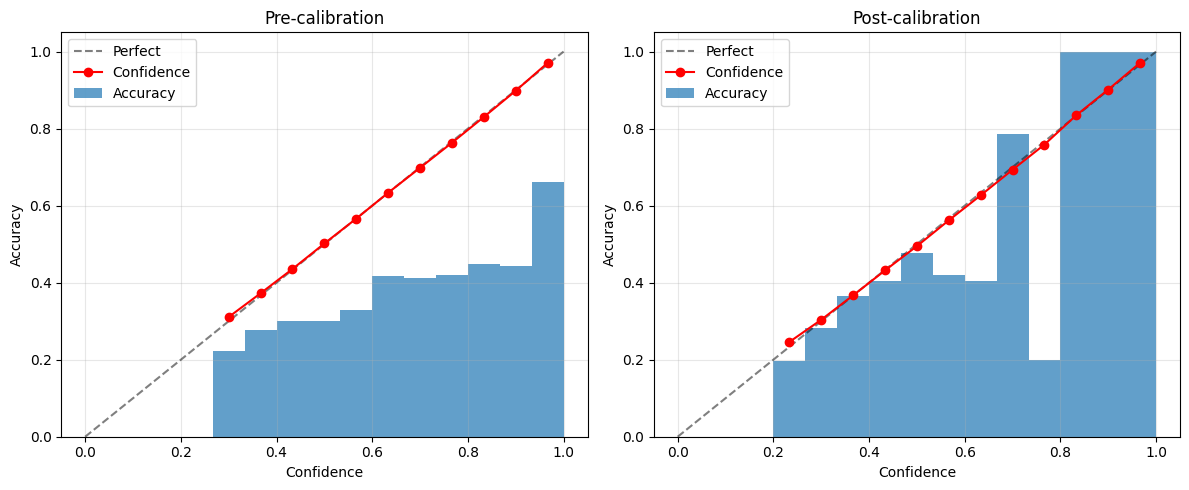

In [9]:
# 8) Temperature calibration + reliability diagram
import json
import numpy as np
import matplotlib.pyplot as plt
import torch
from pathlib import Path

# Collect logits and labels on validation set
model.eval()
all_logits, all_labels = [], []
with torch.no_grad():
    for x, y in val_loader:
        x = x.to(DEVICE)
        logits = model(x)
        all_logits.append(logits.cpu())
        all_labels.append(y)
logits_val = torch.cat(all_logits, dim=0)
labels_val = torch.cat(all_labels, dim=0)

# Temperature scaling
class TemperatureScaler(torch.nn.Module):
    def __init__(self, init_T=1.0, device='cpu'):
        super().__init__()
        self.T = torch.nn.Parameter(torch.tensor([init_T], dtype=torch.float32, device=device))
    def forward(self, logits):
        return logits / self.T.clamp(min=1e-3)

def fit_temperature(logits, labels, steps=200, lr=0.01, device='cpu'):
    ts = TemperatureScaler(device=device)
    opt = torch.optim.LBFGS(ts.parameters(), lr=lr, max_iter=steps, line_search_fn='strong_wolfe')
    criterion = torch.nn.CrossEntropyLoss()
    logits, labels = logits.to(device), labels.to(device)
    def closure():
        opt.zero_grad()
        loss = criterion(ts(logits), labels)
        loss.backward()
        return loss
    opt.step(closure)
    return ts

# Metrics: ECE and Brier (top-label reliability for multiclass)
def compute_ece(y_true, probs, n_bins=15):
    # y_true: (N,) int labels; probs: (N,C)
    conf = probs.max(axis=1)
    preds = probs.argmax(axis=1)
    acc = (preds == y_true)
    bins = np.linspace(0.0, 1.0, n_bins+1)
    ece = 0.0
    for i in range(n_bins):
        m, M = bins[i], bins[i+1]
        sel = (conf > m) & (conf <= M)
        if sel.any():
            bin_conf = conf[sel].mean()
            bin_acc = acc[sel].mean()
            ece += (sel.mean()) * abs(bin_acc - bin_conf)
    return float(ece)

def compute_brier(y_true, probs, num_classes):
    # multiclass Brier against one-hot
    oh = np.eye(num_classes)[y_true]
    return float(np.mean((oh - probs)**2))

# Pre-calibration metrics
probs_pre = torch.softmax(logits_val, dim=1).numpy()
y_true = labels_val.numpy()
ECE_PRE = compute_ece(y_true, probs_pre, n_bins=15)
BRIER_PRE = compute_brier(y_true, probs_pre, num_classes=len(label_map))

# Fit temperature and compute post-calibration metrics
DEVICE_T = 'cuda' if torch.cuda.is_available() else 'cpu'
ts = fit_temperature(logits_val, labels_val, steps=200, lr=0.01, device=DEVICE_T)

with torch.no_grad():
    logits_post = (logits_val.to(DEVICE_T) / ts.T.clamp(min=1e-3)).cpu()
probs_post = torch.softmax(logits_post, dim=1).numpy()

ECE_POST = compute_ece(y_true, probs_post, n_bins=15)
BRIER_POST = compute_brier(y_true, probs_post, num_classes=len(label_map))

print(f"Temperature: {ts.T.item():.4f}")
print(f"ECE  pre={ECE_PRE:.4f}, post={ECE_POST:.4f}")
print(f"Brier pre={BRIER_PRE:.4f}, post={BRIER_POST:.4f}")

# Save temperature for inference
TEMP_PATH = Path(CHECKPOINT_PATH).parent / 'temperature.json'
with open(TEMP_PATH, 'w') as f:
    json.dump({'temperature': float(ts.T.item())}, f)
print(f"Saved temperature to {TEMP_PATH}")

# Reliability diagram (pre vs post)
def plot_reliability(y_true, probs_pre, probs_post, n_bins=15):
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    
    for idx, (probs, title) in enumerate([(probs_pre, 'Pre-calibration'), (probs_post, 'Post-calibration')]):
        conf = probs.max(axis=1)
        preds = probs.argmax(axis=1)
        acc = (preds == y_true)
        bins = np.linspace(0.0, 1.0, n_bins+1)
        
        bin_centers = []
        bin_accs = []
        bin_confs = []
        bin_counts = []
        
        for i in range(n_bins):
            m, M = bins[i], bins[i+1]
            sel = (conf > m) & (conf <= M)
            if sel.any():
                bin_centers.append((m + M) / 2)
                bin_accs.append(acc[sel].mean())
                bin_confs.append(conf[sel].mean())
                bin_counts.append(sel.sum())
        
        axes[idx].plot([0, 1], [0, 1], 'k--', alpha=0.5, label='Perfect')
        axes[idx].bar(bin_centers, bin_accs, width=1.0/n_bins, alpha=0.7, label='Accuracy')
        axes[idx].plot(bin_centers, bin_confs, 'ro-', label='Confidence')
        axes[idx].set_xlabel('Confidence')
        axes[idx].set_ylabel('Accuracy')
        axes[idx].set_title(title)
        axes[idx].legend()
        axes[idx].grid(alpha=0.3)
    
    plt.tight_layout()
    plt.show()

plot_reliability(y_true, probs_pre, probs_post, n_bins=15)

In [10]:
# 9) Operating threshold selection for melanoma (high specificity)
import json
import numpy as np
from pathlib import Path
from sklearn.metrics import roc_curve

# Ensure we know melanoma class index
mel_idx = label_map.get('melanoma', None)
assert mel_idx is not None, "'melanoma' not found in label_map"

# Use post-calibrated probabilities if available
probs_for_thresh = probs_post if 'probs_post' in globals() else probs_pre

# Compute FPR/TPR across thresholds for melanoma vs rest
y_true_bin = (labels_val.numpy() == mel_idx).astype(int)
y_score = probs_for_thresh[:, mel_idx]
fpr, tpr, thr = roc_curve(y_true_bin, y_score)

# Helper to pick threshold at or above target specificity
spec = 1.0 - fpr

def pick_threshold_at_specificity(target_spec=0.95):
    mask = spec >= target_spec
    if not mask.any():
        # Fall back to best achievable
        j = spec.argmax()
        return float(thr[j]), float(spec[j]), float(tpr[j])
    # Among feasible, pick threshold with highest sensitivity
    j = np.argmax(tpr[mask])
    idxs = np.where(mask)[0]
    j = idxs[j]
    return float(thr[j]), float(spec[j]), float(tpr[j])

thr_95, spec_95, sens_95 = pick_threshold_at_specificity(0.95)
thr_90, spec_90, sens_90 = pick_threshold_at_specificity(0.90)
print(f"@95% spec → threshold={thr_95:.3f}, spec={spec_95:.3f}, sens={sens_95:.3f}")
print(f"@90% spec → threshold={thr_90:.3f}, spec={spec_90:.3f}, sens={sens_90:.3f}")

# Save thresholds for inference
OP_PATH = Path('models/checkpoints/operating_points.json')
OP_PATH.parent.mkdir(parents=True, exist_ok=True)
with open(OP_PATH, 'w') as f:
    json.dump({
        'class_index': mel_idx,
        'use_calibrated': bool('probs_post' in globals()),
        'thresholds': {
            'melanoma_spec95': thr_95,
            'melanoma_spec90': thr_90
        }
    }, f)
print(f"Saved operating thresholds to {OP_PATH}")

@95% spec → threshold=0.543, spec=0.951, sens=0.246
@90% spec → threshold=0.483, spec=0.905, sens=0.389
Saved operating thresholds to models/checkpoints/operating_points.json


In [11]:
# 10) Sanity check: calibrated inference on one image
import json
from pathlib import Path
import numpy as np
import torch
import torchvision.transforms as T
from PIL import Image

# Pick one image from val set
sample_row = val_df.iloc[0]
sample_path = Path(IMG_DIR) / f"{sample_row['image_id']}.jpg"
print('Sample:', sample_path)

# Load checkpoint fresh (uses model from earlier cell)
ckpt = torch.load(CHECKPOINT_PATH, map_location=DEVICE)
model.load_state_dict(ckpt['state_dict'])
model.eval()

# Load temperature and operating points from ROOT models/checkpoints
with open(ROOT / 'models' / 'checkpoints' / 'temperature.json', 'r') as f:
    T_json = json.load(f)
T_val = float(T_json['temperature'])

with open(ROOT / 'models' / 'checkpoints' / 'operating_points.json', 'r') as f:
    op = json.load(f)
mel_idx = int(op['class_index'])
thr = float(op['thresholds']['melanoma_spec95'])

# Preprocess and run
_tf = T.Compose([
    T.Resize((IMG_SIZE, IMG_SIZE)),
    T.ToTensor(),
    T.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225])
])
img = Image.open(sample_path).convert('RGB')
x = _tf(img).unsqueeze(0).to(DEVICE)
with torch.no_grad():
    logits = model(x) / max(1e-6, T_val)
    probs = torch.softmax(logits, dim=1).squeeze(0).cpu().numpy()

pred_idx = int(np.argmax(probs))
mel_prob = float(probs[mel_idx])
verdict = 'melanoma' if mel_prob >= thr else 'non-melanoma'
print(f"Top-1: {id2label[pred_idx]} | melanoma p={mel_prob:.3f} vs thr={thr:.3f} → {verdict}")

Sample: /home/the/Codes/Melanoma-detection/data/ds/img/ISIC_0026592.jpg
Top-1: melanoma | melanoma p=0.251 vs thr=0.724 → non-melanoma
